In [20]:
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as md
from pandas.plotting import register_matplotlib_converters

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR

import pandas as pd
import numpy as np

In [21]:
trips_one_month = pd.read_csv('.\RExtractor\output\JC-201901-citibike-tripdata.csv')
stations = pd.read_csv('.\RExtractor\output\stationTable.csv')
ride = pd.read_csv('.\RExtractor\output\Test.csv')

In [22]:
# Conversion d'un string en datetime
def convertStringToDatetime(hour, minute, second):
    date_time_str = str(hour)+':'+str(minute)+':'+str(round(second,3))
    date_time_obj = datetime.strptime(date_time_str, '%H:%M:%S.%f')
    date_time_obj = pd.to_datetime(date_time_obj)
    return date_time_obj

In [23]:
# Réalise le range d'intevalle pour un delta donné
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta



In [24]:
# Retourne
# La liste des dates où un vélo part d'une station
# La liste des dates où un vélo arrive à une station
# La liste des temps de trajets
def getDateData(dataset, mode="timestamp") : 
    dataset = dataset.reset_index(drop=True)
    s_day = dataset['start_day']
    s_month = dataset['start_month']
    s_year = dataset['start_year']
    s_hour = dataset['start_hour']
    s_minute = dataset['start_minute']
    s_second = dataset['start_second']

    e_day = dataset['end_day']
    e_month = dataset['end_month']
    e_year = dataset['end_year']
    e_hour = dataset['end_hour']
    e_minute = dataset['end_minute']
    e_second = dataset['end_second']
    
    data_s = []
    data_e = []
    data_diff = []
    for i in range(len(dataset)):
        start_date = convertStringToDatetime(s_hour[i], s_minute[i], s_second[i])
        end_date = convertStringToDatetime(e_hour[i], e_minute[i], e_second[i])
        delta = end_date-start_date
        if(mode =="timestamp"):
            data_s.append(start_date.timestamp())
            data_e.append(end_date.timestamp())
            data_diff.append(delta.total_seconds())
        else:
            data_s.append(start_date) 
            data_e.append(end_date)
            data_diff.append(delta)
    return data_s, data_e, data_diff

Test MSE: 2041477.334


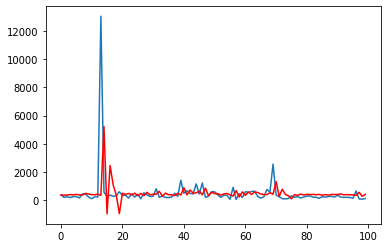

In [25]:
# Autoregression pour estimer le temps de trajet à partir d'une date de départ

def predict(coef, history):
	yhat = coef[0]
	for i in range(1, len(coef)):
		yhat += coef[i] * history[-i]
	return yhat
data_s, data_e, data_diff = getDateData(trips_one_month)

train, test = data_diff[0:100], data_diff[100:200]
# train autoregression
model = AR(train)
model_fit = model.fit(maxlag=6, disp=False)
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
	yhat = predict(coef, history)
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [26]:
# TODO : faire couple start/end -> on a le départ et on prédit l'arrivée
# Todo : faire une prédiction du flux moyen sur la durée pour une station


# Liste d'intervalles de 30 min sur une journée
dts30 = [dt.strftime('%H:%M:%S.%f') for dt in 
       datetime_range(datetime(2019,1, 1, 0), datetime(2019,1,1, 23, 59), 
       timedelta(minutes=30))]

In [27]:

dataset_station_s = trips_one_month[trips_one_month.start_station_id == 3183]

dataset_station_e = trips_one_month[trips_one_month.end_station_id == 3183]


In [28]:
dataset_station_s_one_day = dataset_station_s[trips_one_month.start_day%7 == 2]
dataset_station_s_one_day.reset_index(drop=True)
dataset_station_e_one_day = dataset_station_e[trips_one_month.start_day%7 == 2]
dataset_station_e_one_day.reset_index(drop=True)

dataset_station_s_second_day = dataset_station_s[trips_one_month.start_day%7 == 1]
dataset_station_s_second_day.reset_index(drop=True)
dataset_station_e_second_day = dataset_station_e[trips_one_month.start_day%7 == 1]
dataset_station_e_second_day.reset_index(drop=True) 

C:\Users\Kim-anh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Kim-anh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Kim-anh\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Kim-anh\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,tripduration,start_station_id,end_station_id,bikeid,usertype,birth.year,gender,start_day,start_month,start_year,start_hour,start_minute,start_second,end_day,end_month,end_year,end_hour,end_minute,end_second
0,111,3183,3183,29453,Subscriber,1987,1,1,1,2019,21,52,9.298,1,1,2019,21,54,0.455
1,663,3183,3183,29286,Subscriber,1987,1,1,1,2019,21,54,27.936,1,1,2019,22,5,31.880
2,90,3183,3183,29201,Subscriber,1974,2,8,1,2019,21,21,6.342,8,1,2019,21,22,37.111
3,929,3184,3183,29453,Subscriber,1971,1,1,1,2019,12,51,44.128,1,1,2019,13,7,13.321
4,92,3184,3183,29213,Subscriber,1986,1,8,1,2019,5,36,11.511,8,1,2019,5,37,44.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,158,3681,3183,29619,Subscriber,1974,1,22,1,2019,7,43,22.684,22,1,2019,7,46,0.817
183,121,3681,3183,29290,Subscriber,1988,2,29,1,2019,7,16,4.954,29,1,2019,7,18,6.028
184,161,3681,3183,29657,Subscriber,1974,1,29,1,2019,7,27,23.176,29,1,2019,7,30,4.264
185,1053,3694,3183,29548,Subscriber,1977,1,15,1,2019,6,32,7.277,15,1,2019,6,49,40.845


In [29]:
data_s,_, _ = getDateData(dataset_station_s_one_day, "notimestamp")
_ ,data_e, _ = getDateData(dataset_station_e_one_day, "notimestamp")

data_s2,_, _ = getDateData(dataset_station_s_second_day, "notimestamp")
_ ,data_e2, _ = getDateData(dataset_station_e_second_day, "notimestamp")

In [30]:
l1 = [-1]*len(data_s)
l2 = [1]*len(data_e)

l3 = [-1]*len(data_s2)
l4 = [1]*len(data_e2)

In [31]:
data_s = list(zip(data_s,l1))
data_e = list(zip(data_e,l2))
d = data_s + data_e
d.sort(key=lambda tup: tup[0])

data_s2 = list(zip(data_s2,l3))
data_e2 = list(zip(data_e2,l4))
d2 = data_s2 + data_e2
d2.sort(key=lambda tup: tup[0])

In [32]:

def bike_per_hour(data):
    bike_per_hours_list = []
    for hours in range(0,24):
        hour_first_half = 0
        hour_second_half = 0
        count_first_half = 0
        count_second_half = 0
        for date in data:
            if(hours == date[0].hour):
                if(date[0].minute <= 30):
                    count_first_half += 1
                    hour_first_half += date[1]
                else : 
                    count_second_half += 1
                    hour_second_half += date[1]
        if(count_first_half == 0):
            bike_per_hours_list.append(0)
        else:
            bike_per_hours_list.append(hour_first_half/count_first_half)
        if(count_second_half == 0):
            bike_per_hours_list.append(0)
        else:
            bike_per_hours_list.append(hour_second_half/count_second_half)
            
    return bike_per_hours_list

In [33]:
data_diff = bike_per_hour(d)
data_diff2 = bike_per_hour(d2)



train, test = data_diff, data_diff2
# train autoregression
model = AR(train)
model_fit = model.fit(maxlag=6, disp=False)
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
	yhat = predict(coef, history)
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)



Test MSE: 0.270


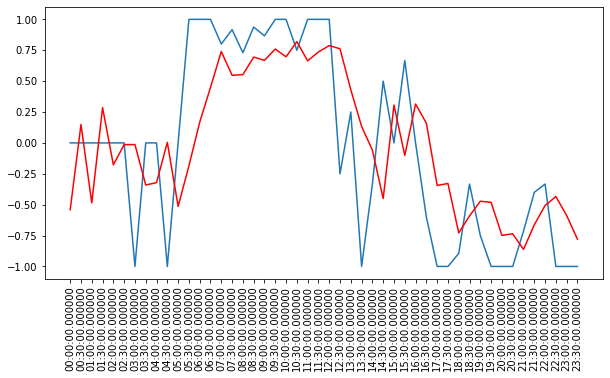

In [34]:


dates = np.arange(0,24,0.5)
xfmt = md.DateFormatter('%H:%M:%S')
plt.rcParams['figure.figsize'] = [10, 5]
plt.xticks(rotation= 90, )
plt.plot(dts30, test)
plt.plot(dts30, predictions, color='red')
plt.show()